# Model Performance Evaluation
Work for Masters Thesis

Stanley Fujimoto

In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib inline

/Users/masaki/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
available_features_str = "aliscore,length,num_seqs,num_gaps,num_amino_acids,range,amino_acid_charged,amino_acid_uncharged,amino_acid_special,amino_acid_hydrophobic"
available_features = available_features_str.split( ',' )

## Metaclassifier code

In [20]:
# code for meta classifier
available_models = "svm,neural_network,random_forest,naive_bayes,logistic_regression"

class Metaclassifier:
    '''
    a meta-classifier that uses several other base classifiers to produce its own classifications
    '''

    def __init__( self, model_names = available_models.split( ',' ) ):
        '''
        model_names = a python list of model names, the model names should correspond to the used models
        '''
        self.model_names = model_names
        for x in model_names:
            model_class = model_to_class[ x ]
            self.models = [ model_class( **( model_params[ model_class ] ) ) for x in model_names ]
        self.skip_models = [ 0 ] * len( self.models )
        self.models.append( MLPClassifier() )

    def generate_base_classifier_predictions( self, x, sx ):
        predictions = []
        # create predictions for all classifier except for the last one, the meta-classifier
        for idx, model in enumerate( self.models[ : -1 ] ):
            # if the model was untrainable during the bootstrapping process, we mark everything
            # as a homology cluster
            if self.skip_models[ idx ] == 1:
                predictions.append( np.array( [ 'H' ] * len( x ) ) )
            else:
                if isinstance( model, MultinomialNB ):
                    predictions.append( model.predict( x ) )
                else:
                    predictions.append( model.predict( sx ) )

        predictions = pd.DataFrame( predictions ).replace( { 'H' : 1, "NH" : 0 } ).transpose()
        predictions.columns = self.model_names
        return predictions

    def train_base_classifiers( self, x, sx, y ):
        for idx, model in enumerate( self.models[ : -1 ] ):
            try:
                if isinstance( model, MultinomialNB ):
                    # don't scale for NB
                    model.fit( x, y )
                else:
                    # scale it for all others
                    model.fit( sx, y )
            except ValueError:
                # could not train the model
                # should only happen during bootstrap analysis when both H and NH are not present in
                # the training data, not too concerned about this
                # mark a model as untrained
                self.skip_models[ idx ] = 1
            #except ConvergenceWarning:
            #    # the model didn't converge
            #    pass

    def fit( self, x, sx, y ):
        self.train_base_classifiers( x, sx, y )
        predictions = self.generate_base_classifier_predictions( x, sx )
        try:
            self.models[ -1 ].fit( predictions, y )
        except:
            pass
        #except ConvergenceWarning:
        #    # the model didn't converge
        #    pass

    def predict( self, x, sx ):
        predictions = self.generate_base_classifier_predictions( x, sx )
        return self.models[ -1 ].predict( predictions )

model_to_class = {
        "svm" : SVC,
        "neural_network" : MLPClassifier,
        "random_forest" : RandomForestClassifier,
        "naive_bayes" : MultinomialNB,
        "logistic_regression" : LogisticRegression,
        "metaclassifier" : Metaclassifier
        }

model_params = {
        SVC : {
            "kernel" : "poly",
            "cache_size" : 4000
            },
        RandomForestClassifier : {},
        MultinomialNB : {},
        LogisticRegression : {},
        Metaclassifier : {
            "model_names" : [ "svm", "neural_network", "naive_bayes", "logistic_regression" ]
            },
        MLPClassifier : {}
        }


## Data Prep

In [4]:
# load data
data = pickle.load( open( "../data/featurized_data.pickle", "rb" ) )

### split the data

In [5]:
# sdata is the scaled data, data is unscaled
shuffled_data = data.copy()
shuffled_data = shuffle( shuffled_data )
scaled_shuffled_data = shuffled_data.copy()
scaled_shuffled_data[ available_features ] = scale( shuffled_data[ available_features ] )
sdata = scaled_shuffled_data.copy()

## Model Testing

#### Model testing parameters

In [6]:
bootstrap_percentages_str = "1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100"
#bootstrap_percentages_str = "10,20,30,40,50,60,70,80,90,100"
bootstrap_percentages = map( float, bootstrap_percentages_str.split( ',' ) )
replicates = 20

In [7]:
# bootstrap function

def bootstrap( model, model_params = {}, data = None, sdata = None ):
    #mdata = sdata.copy()
    #svm_data[ available_features ] = scale( svm_data[ available_features ] )
    #svm_train, svm_test = train_test_split( svm_data, test_size = 0.2 )
    #svm_x_test = test[ available_features ]
    #svm_y_test = test[ "class" ]

    acc_train = []
    acc_test = []
    for perc in bootstrap_percentages:
        # resample data
        num_instances = int( math.ceil( len( data ) * ( perc / 100 ) ) )

        acc_perc_train = []
        acc_perc_test = []

        for rep in range( replicates ):
            train, test, strain, stest = train_test_split( data, sdata, test_size = 0.2 )
            x_test = test[ available_features ]
            sx_test = stest[ available_features ]
            
            test_labels = test[ "class" ]
            
            sub_train = train.sample( num_instances, replace = True )
            sub_strain = strain.loc[ sub_train.index ]

            x_train = sub_train[ available_features ]
            sx_train = sub_strain[ available_features ]

            train_labels = sub_train[ "class" ]

            #print "\trep:", rep
            mod = model( **model_params )
            try:
                if isinstance( mod, Metaclassifier ):
                    mod.fit( x_train, sx_train, train_labels )
                    
                    preds = mod.predict( x_train, sx_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( x_test, sx_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
                elif isinstance( mod, MultinomialNB ):
                    mod.fit( x_train, train_labels )
                    
                    preds = mod.predict( x_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( x_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
                else:
                    mod.fit( sx_train, train_labels )
            
                    preds = mod.predict( sx_train )
                    acc_perc_train.append( accuracy_score( preds, train_labels ) )
                    
                    preds = mod.predict( sx_test )
                    acc_perc_test.append( accuracy_score( preds, test_labels ) )
            except ValueError as e:
                print x_train

            # train dataset
            

            # test dataset
            

        print "perc:", perc, np.mean( acc_perc_train ), np.mean( acc_perc_test ), np.std( acc_perc_train ), np.std( acc_perc_test )
        acc_train.append( acc_perc_train )
        acc_test.append( acc_perc_test )
    return acc_train, acc_test

In [8]:
# plot generation
def gen_plot( model, acc_train, acc_test, y_lim_min = 0.5, y_lim_max = 1.0 ):
    acc_train_ = np.asarray( acc_train )
    acc_test_ = np.asarray( acc_test )

    avgs_train = acc_train_.mean( axis = 1 )
    errs_train = acc_train_.std( axis = 1 )

    avgs_test = acc_test_.mean( axis = 1 )
    errs_test = acc_test_.std( axis = 1 )

    avgs = pd.DataFrame( [ avgs_train, avgs_test ] ).transpose()
    avgs.columns = [ "Train", "Test" ]
    avgs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = avgs.index )
    avgs.set_index( "perc", inplace = True )

    errs = pd.DataFrame( [ errs_train, errs_test ] ).transpose()
    errs.columns = [ "Train", "Test" ]
    errs[ "perc" ] = pd.Series( map( int, bootstrap_percentages_str.split( ',' ) ), index = errs.index )
    errs.set_index( "perc", inplace = True )

    fig, ax = plt.subplots()
    fig.set_size_inches( 12, 8, forward = True )
    plt.title( model + " accuracy" )
    plt.ylim( y_lim_min, y_lim_max )
    plt.xlabel( "% of total training set" )
    plt.ylabel( "% accuracy" )
    avgs.plot.line( ax = ax, color = [ 'b', 'r' ] )
    plt.fill_between( avgs.index, avgs[ "Train" ] - errs[ "Train" ], avgs[ "Train" ] + errs[ "Train" ], facecolor = 'blue', alpha = 0.2 )
    plt.fill_between( avgs.index, avgs[ "Test" ] - errs[ "Test" ], avgs[ "Test" ] + errs[ "Test" ], facecolor = 'red', alpha = 0.2 )
    plt.xticks( avgs.index.values, map( str, avgs.index.values ), fontsize = 8 )
    leg = plt.legend( fontsize = 8 )
    
    

### SVM

In [9]:
svm_acc_train, svm_acc_test = bootstrap( SVC, model_params = { "kernel" : "poly", "cache_size" : 4000 }, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.640760869565 0.574359673025 0.0253694348195 0.0332610280293
perc: 2.0 0.68125 0.638283378747 0.050816670521 0.0455185654658
perc: 3.0 0.674094202899 0.63795640327 0.0256319774339 0.0234112278569
perc: 4.0 0.687602179837 0.66651226158 0.046539597279 0.0515746955041
perc: 5.0 0.678758169935 0.66280653951 0.0404283281014 0.03918133911
perc: 6.0 0.696007259528 0.676076294278 0.0375794541576 0.0409769404984
perc: 7.0 0.705443234837 0.678746594005 0.0379401110214 0.040113767338
perc: 8.0 0.72091280654 0.700980926431 0.0407748051158 0.0474095962558
perc: 9.0 0.725484261501 0.705749318801 0.0536209945663 0.055216079354
perc: 10.0 0.718899782135 0.704032697548 0.0451031369142 0.0517225930634
perc: 15.0 0.756867732558 0.743269754768 0.0517273799097 0.0593812682768
perc: 20.0 0.783378746594 0.773869209809 0.0461015775053 0.0537271318492
perc: 25.0 0.789729611862 0.779046321526 0.045259987767 0.045220272044
perc: 30.0 0.834992732558 0.826158038147 0.0353602124218 0.0368510855944
perc: 

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


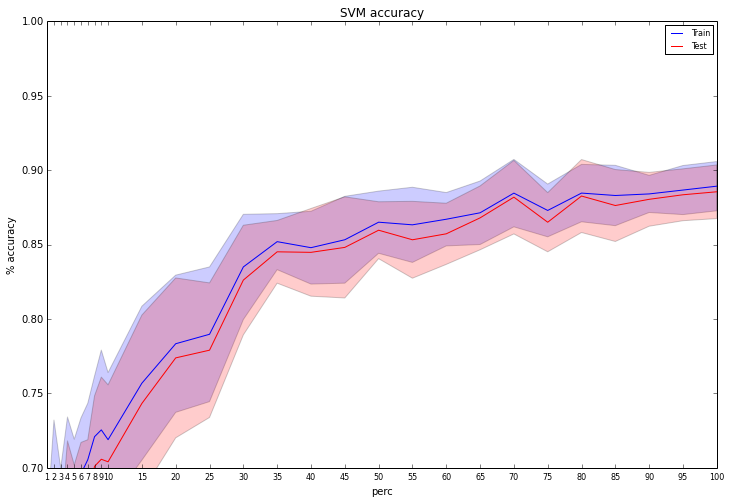

In [10]:
gen_plot( "SVM", svm_acc_train, svm_acc_test, y_lim_min = 0.7 )
plt.show()

### MLP

In [11]:
mlp_acc_train, mlp_acc_test = bootstrap( MLPClassifier, data = shuffled_data, sdata = scaled_shuffled_data )

/Library/Python/2.7/site-packages/numpy-1.11.0rc2-py2.7-macosx-10.11-intel.egg/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/Users/masaki/Library/Python/2.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:560: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


perc: 1.0 0.894565217391 0.8189373297 0.0291863512654 0.0187776776394
perc: 2.0 0.882880434783 0.836076294278 0.0227661609854 0.0124908626554
perc: 3.0 0.89981884058 0.867629427793 0.0163756492469 0.00885604693832
perc: 4.0 0.901089918256 0.875858310627 0.0169966977371 0.0124801589521
perc: 5.0 0.916448801743 0.898119891008 0.0101084394366 0.0119524768826
perc: 6.0 0.925136116152 0.902370572207 0.0096184467254 0.00957683300011
perc: 7.0 0.935147744946 0.915367847411 0.013478386569 0.0136360709275
perc: 8.0 0.948365122616 0.928092643052 0.0075965132749 0.0088821233062
perc: 9.0 0.942675544794 0.926348773842 0.01020312523 0.00966327174611
perc: 10.0 0.955337690632 0.940190735695 0.00581540209806 0.00580803469409
perc: 15.0 0.967659883721 0.956784741144 0.00329448458042 0.00533976526878
perc: 20.0 0.962779291553 0.954059945504 0.00824690809598 0.00895973134533
perc: 25.0 0.97078063672 0.960490463215 0.00384420425138 0.0053713732732
perc: 30.0 0.972601744186 0.965177111717 0.00366519796771

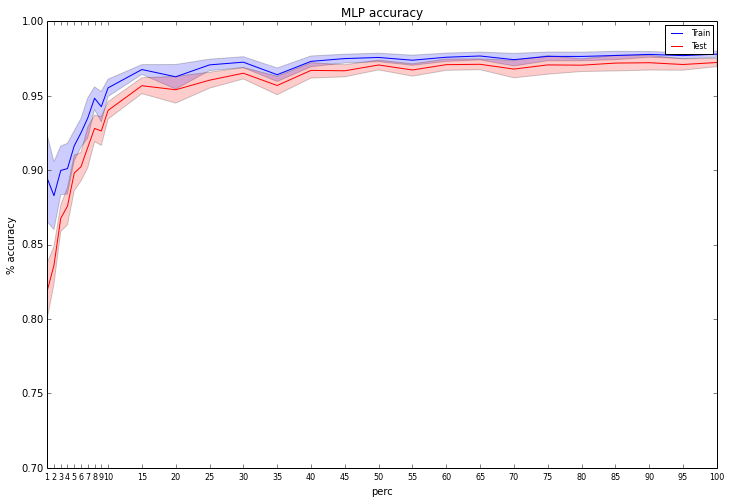

In [12]:
gen_plot( "MLP", mlp_acc_train, mlp_acc_test, y_lim_min = 0.7 )
plt.show()

### Logistic Regression

In [13]:
lr_acc_train, lr_acc_test = bootstrap( LogisticRegression, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.850543478261 0.829918256131 0.0208726786627 0.0277773638169
perc: 2.0 0.879891304348 0.857438692098 0.0252527394685 0.0161884968237
perc: 3.0 0.886413043478 0.874577656676 0.013177402242 0.0158153439107
perc: 4.0 0.898773841962 0.888119891008 0.0112106384617 0.0133287912336
perc: 5.0 0.898692810458 0.894223433243 0.0125815814536 0.0102488543656
perc: 6.0 0.909165154265 0.895340599455 0.00781611770695 0.0125783779939
perc: 7.0 0.91267496112 0.90485013624 0.0109890193281 0.0109378062237
perc: 8.0 0.916961852861 0.909782016349 0.0071115991722 0.0103031509672
perc: 9.0 0.917433414044 0.918446866485 0.00762423559023 0.00737060998142
perc: 10.0 0.923638344227 0.916321525886 0.00727404619817 0.0105706268658
perc: 15.0 0.933611918605 0.930108991826 0.00460938610024 0.00774891831093
perc: 20.0 0.939782016349 0.933732970027 0.00423352928815 0.00623591374926
perc: 25.0 0.944679459224 0.940980926431 0.00308152613519 0.00484094282233
perc: 30.0 0.946457122093 0.941934604905 0.0034896493

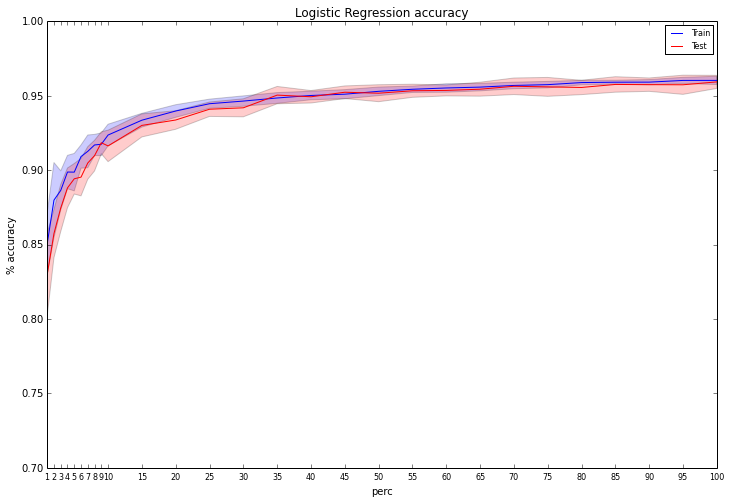

In [14]:
gen_plot( "Logistic Regression", lr_acc_train, lr_acc_test, y_lim_min = 0.7 )
plt.show()

### Random Forest

In [15]:
rf_acc_train, rf_acc_test = bootstrap( RandomForestClassifier, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.989130434783 0.741825613079 0.0119070121197 0.0288657987911
perc: 2.0 0.988586956522 0.790762942779 0.00640751419704 0.0176750627511
perc: 3.0 0.989492753623 0.815340599455 0.00442266507816 0.0130668369697
perc: 4.0 0.990190735695 0.83553133515 0.00669656987872 0.0115250803308
perc: 5.0 0.991721132898 0.837738419619 0.00405252183829 0.0131242123374
perc: 6.0 0.993103448276 0.848365122616 0.00370164755978 0.00897591689866
perc: 7.0 0.992379471229 0.855940054496 0.00286344520055 0.00803934780669
perc: 8.0 0.99529972752 0.861662125341 0.00199650557081 0.0117606106608
perc: 9.0 0.994249394673 0.866321525886 0.0022930625817 0.00730550182371
perc: 10.0 0.994008714597 0.871389645777 0.00293309630018 0.00743025342028
perc: 15.0 0.994912790698 0.882234332425 0.00159221673693 0.00755687574154
perc: 20.0 0.995449591281 0.889155313351 0.00171705370618 0.00850625165072
perc: 25.0 0.995486262538 0.899482288828 0.00129573087804 0.00626223012496
perc: 30.0 0.99636627907 0.899918256131 0.00

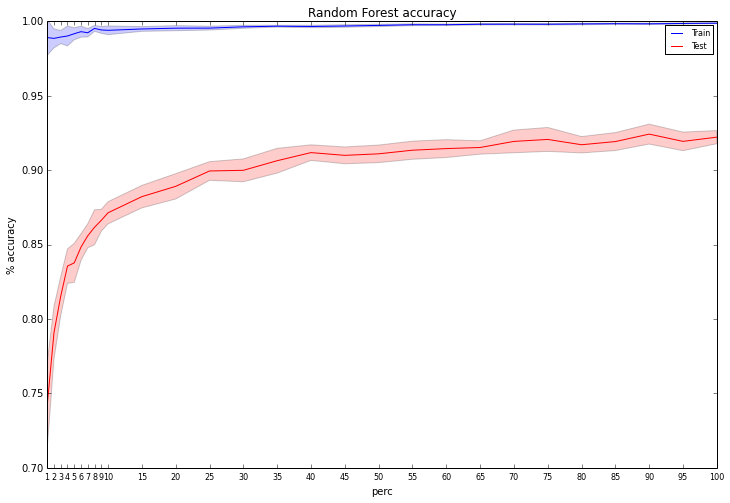

In [16]:
gen_plot( "Random Forest", rf_acc_train, rf_acc_test, y_lim_min = 0.7 )
plt.show()

### Naive Bayes

In [17]:
# naive bayes can't handle values that are <0, don't use scaled values 'sdata', use 'data'
nb_acc_train, nb_acc_test = bootstrap( MultinomialNB, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.721195652174 0.711907356948 0.0551329163822 0.0180752969933
perc: 2.0 0.705163043478 0.711553133515 0.0274913523953 0.0115411742122
perc: 3.0 0.716304347826 0.708092643052 0.027714431025 0.009185875743
perc: 4.0 0.708583106267 0.709209809264 0.0247563091961 0.0136961575719
perc: 5.0 0.706535947712 0.713460490463 0.0157270711314 0.00845407093658
perc: 6.0 0.706715063521 0.714059945504 0.0213848251494 0.0122113412197
perc: 7.0 0.713297045101 0.71068119891 0.0187934430453 0.00923042369897
perc: 8.0 0.712261580381 0.706839237057 0.0206150194217 0.00903461867365
perc: 9.0 0.71313559322 0.70931880109 0.0167730168286 0.00974304015394
perc: 10.0 0.712908496732 0.711525885559 0.0158288837895 0.009742849644
perc: 15.0 0.708684593023 0.710408719346 0.0129459945907 0.0123290905656
perc: 20.0 0.709591280654 0.710108991826 0.0109411996645 0.0117229246082
perc: 25.0 0.711055385957 0.708555858311 0.0100942956798 0.00831594058906
perc: 30.0 0.710755813953 0.709237057221 0.00819724274181 0.0

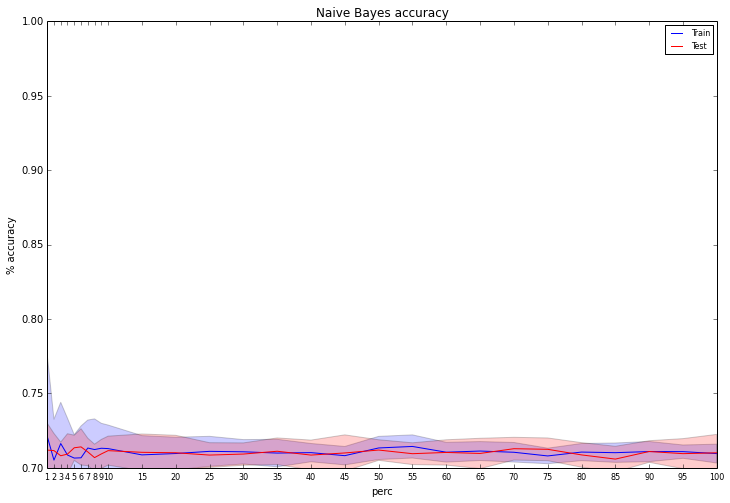

In [18]:
gen_plot( "Naive Bayes", nb_acc_train, nb_acc_test, y_lim_min = 0.7 )
plt.show()

### Meta

In [21]:
meta_acc_train, meta_acc_test = bootstrap( Metaclassifier, model_params = { "model_names" : [ "svm", "neural_network", "naive_bayes", "logistic_regression" ] }, data = shuffled_data, sdata = scaled_shuffled_data )

perc: 1.0 0.86902173913 0.828664850136 0.0349647067532 0.0162242304339
perc: 2.0 0.876902173913 0.864686648501 0.0208567527473 0.0168929418818
perc: 3.0 0.880253623188 0.874277929155 0.0158128411815 0.0143201945308
perc: 4.0 0.89727520436 0.883514986376 0.0120969879457 0.0145840216312
perc: 5.0 0.901525054466 0.894223433243 0.00816920839183 0.0125351261245
perc: 6.0 0.905444646098 0.89970027248 0.0084328567372 0.00776155539098
perc: 7.0 0.913219284603 0.9010626703 0.0085267497119 0.00946171308917
perc: 8.0 0.914713896458 0.907384196185 0.00901038461242 0.0105199345393
perc: 9.0 0.916162227603 0.911662125341 0.007693845096 0.00835921828746
perc: 10.0 0.920806100218 0.9189373297 0.007234788635 0.00804414868549
perc: 15.0 0.935973837209 0.927711171662 0.00423074987728 0.006134785256
perc: 20.0 0.939346049046 0.935640326975 0.00483480416551 0.008810659462
perc: 25.0 0.943916266899 0.93825613079 0.00469583245701 0.00502161429389
perc: 30.0 0.944949127907 0.945476839237 0.00327942055737 0.00

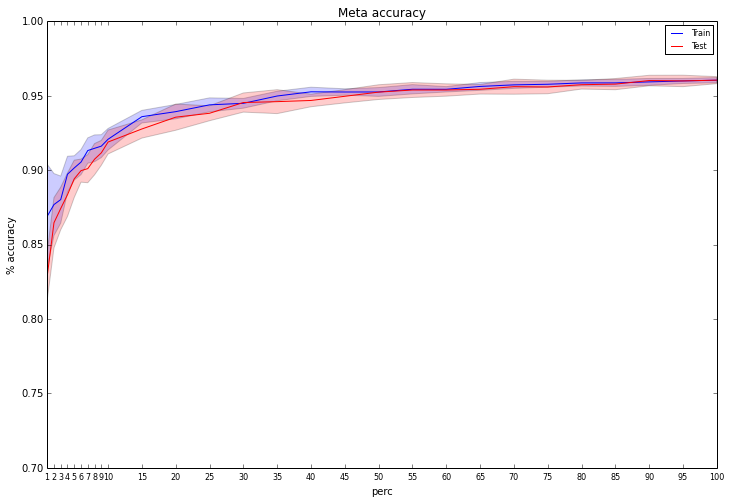

In [22]:
gen_plot( "Meta", meta_acc_train, meta_acc_test, y_lim_min = 0.7 )
plt.show()